# Dataset effects
- Some exploratory analysis: check completeness  
- Plot the individual dataset effects  
- Statistical tests for individual effects  
- Plot the interaction effects  
- Statistical tests for the interaction effects  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import json
import numpy as np
import pandas as pd 
import scipy
import seaborn as sns

from pathlib import Path

In [2]:
ft_tasks = ["cola", "sst2", "mrpc", "stsb", "qnli", "rte"]
probing_tasks = ["Length", "Depth", "TopConstituents", "BigramShift", "Tense", "SubjNumber", "ObjNumber", "OddManOut", "CoordinationInversion"]
experiments = [
    "100000", "010000", "001000", "000100", "000010", "000001", 
    "110000", "101000", "100100", "100010", "100001", "011000", 
    "010100", "010010", "010001", "001100", "001010", "001001",
    "000110", "000101", "000011", "101010", "101001", "100110",
    "100101", "011010", "011001", "010110", "010101", "111100",
    "110011", "001111", "111111"]
# 100000 means cola only. 110000 means cola & sst2, so on.

all_random_seeds = [1,10,42,123,1234]

In [7]:
def check_completeness(model="bert"):
    print ("Checking completness for model", model)
    for rs in all_random_seeds:
        for expid in range(len(experiments)+1):
            p = Path("../experiments", model, str(rs), str(expid), "test_results.json")
            if p.exists():
                ft_results = json.loads(p.read_text())
            elif expid > 0:
                print (f"expid={expid}, rs={rs} finetune results not found.")
            
            p = Path("../experiments", model, str(rs), str(expid), "probe_results.json")
            if p.exists():
                probing_results = json.loads(p.read_text())
            else:
                print (f"expid={expid}, rs={rs} probing results not found.")
    print("Done")

check_completeness("bert")
check_completeness("roberta")

Checking completness for model bert
Done
Checking completness for model roberta
Done


In [4]:
def condition_to_experiment_id(condition=[]):
    if len(condition) == 0:
        return 0
    L = ["0"] * len(ft_tasks)
    for i, t in enumerate(ft_tasks):
        if t in condition:
            L[i] = "1"
    s = "".join(L)
    if s not in experiments:
        raise ValueError("Condition {} not in experiments".format(condition))
    else:
        return experiments.index(s)+1

def p_to_stars(p, bonferroni=1):
    if p < 0.001 / bonferroni:
        return "***"
    elif p < 0.01 / bonferroni:
        return "**"
    elif p < 0.05 / bonferroni:
        return "*"
    else:
        return ""
        
def get_probing_results(model, expid, rs, features, attr="acc"):
    """
    attr should be either "acc" or "devacc".
    Returns an np.array (len=len of probing tasks)
    """
    p = Path("../experiments", model, str(rs), str(expid), "probe_results.json")
    if not p.exists():
        raise ValueError("{} doesn't exist!".format(p))
    L = json.loads(p.read_text())
    return np.array([L[task][attr] for task in L if task in features])


def find_individual_effect(model="roberta", condition=[], target="cola", features=["Depth", "Tense"]):
    expid_start = condition_to_experiment_id(condition)
    expid_end = condition_to_experiment_id(condition + [target])
    print ("expid_start: {}, expid_end: {}".format(expid_start, expid_end))
    
    s_start = np.vstack([get_probing_results(model, expid_start, rs, features) for rs in all_random_seeds])
    s_end = np.vstack([get_probing_results(model, expid_end, rs, features) for rs in all_random_seeds])
    # each state is an np.array of shape [n_rs, n_probing_results]

    return s_start, s_end 

#find_individual_effect("roberta", ["cola"], target="sst2", features=["Depth", "Tense"])   

expid_start: 18, expid_end: 27
Dataset effect: {'Depth': (-0.5799999999999947, ''), 'Tense': (-1.2199999999999989, '')}


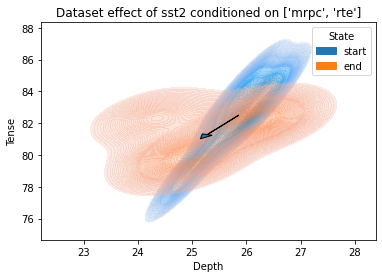

In [14]:
def compute_individual_effect(model, condition, target, features, plot=True):
    s_start, s_end = find_individual_effect(model, condition, target, features)
    
    ssc = s_start.mean(axis=0)  # state start centroid
    sec = s_end.mean(axis=0)
    diff = sec - ssc

    sigtest_results = []
    for i in range(len(features)):
        t, p = scipy.stats.ttest_ind(s_start[:,i], s_end[:,i])
        sigtest_results.append(p_to_stars(p))
    print("Dataset effect: {}".format({f:(d, sigtest) for (f,d, sigtest) in zip(features, diff, sigtest_results)}))

    if plot:
        plt.figure()
        # Scatterplot
        # plt.scatter(s_start[:, 0], s_start[:, 1], color="b")
        # plt.scatter(s_end[:, 0], s_end[:, 1], color="g")

        # KDE plot
        plotdata = {
            "State": ["start"] * len(s_start) + ["end"] * len(s_end)
        }
        for i, feat in enumerate(features):
            plotdata[feat] = np.concatenate([s_start[:, i], s_end[:, i]])
        plotdata = pd.DataFrame(plotdata)
        sns.kdeplot(data=plotdata, x=features[0], y=features[1], 
            hue="State", levels=100, fill=True, alpha=0.3)
    
        # Display an arrow showing the dataset effect
        plt.arrow(ssc[0], ssc[1], diff[0], diff[1], head_width=0.2)
    
        # Others
        plt.title("Dataset effect of {} conditioned on {}".format(target, condition))
        #plt.xlim([0, 100])
        #plt.ylim([0, 100])
        #plt.show()
        plt.savefig("figures/ind_{}_feat={}.png".format(target, ",".join(features)), dpi=150)


#compute_individual_effect("roberta", [], target="cola", features=["OddManOut", "CoordinationInversion"])
#compute_individual_effect("roberta", ["mrpc"], target="sst2", features=["Depth", "Tense"])
#compute_individual_effect("roberta", ["mrpc", "qnli"], target="sst2", features=["Depth", "Tense"])
compute_individual_effect("roberta", ["mrpc", "rte"], target="sst2", features=["Depth", "Tense"])

## Interaction effect
Consider the $k^{th}$ linguistic ability dimension, the effect is $e^k$. Specify the indicator variables $i_x$ and $i_y$, where $i_x=0$ if there is no dataset x, and $i_x=1$ otherwise. Then, fit a linear regression:  
$$s_k = \beta_0 + \beta_1 i_x + \beta_2 i_y + \beta_3 i_{xy} + \epsilon$$
Use the following experiments:  
(1) $i_x=0, i_y=0$, where $s_k = S(I)_k$  
(2) $i_x=0, i_y=1$, where $s_k = S(y)_k$  
(3) $i_x=1, i_y=0$, where $s_k = S(x)_k$  
(4) $i_x=1, i_y=1$, where $s_k = S([x,y])_k$  
Each experiment contains 5 random seeds, so there are 20 rows in total, to fit 4 parameters ($\beta_0..\beta_3$).

$\beta_3$ is the coefficient for interaction effect, as plotted by the blue arrow in the figures.  
Coincidentally, the red arrow is computed from $E([x,y]) - E(x) - E(y)$, which happens to be exactly the same. This is a geometric interpretation of the interaction effect

/Users/zhuzi/miniforge3/envs/transformers4/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


,feature,interaction_eff,p_value,significance
0,SubjNumber,-0.20,0.799968,
1,Depth,-0.94,0.345657,


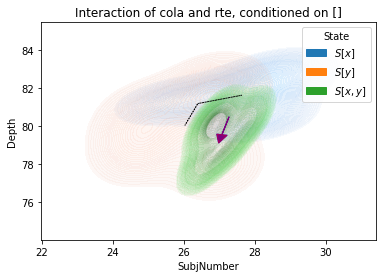

In [16]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

def compute_interaction_effect(model, condition, targetx, targety, features, plot=True, plot_fname="testfig.svg"):
    expid_base = condition_to_experiment_id(condition)
    expid_x = condition_to_experiment_id(condition + [targetx])
    expid_y = condition_to_experiment_id(condition + [targety])
    expid_xy = condition_to_experiment_id(condition + [targetx, targety])
    
    # Each s is np.array [n_rs, len(features)]
    s_base = np.vstack([get_probing_results(model, expid_base, rs, features) for rs in all_random_seeds])
    s_x = np.vstack([get_probing_results(model, expid_x, rs, features) for rs in all_random_seeds])
    s_y = np.vstack([get_probing_results(model, expid_y, rs, features) for rs in all_random_seeds])
    s_xy = np.vstack([get_probing_results(model, expid_xy, rs, features) for rs in all_random_seeds])

    n_rs = len(s_base)

    eff_int = []
    p_values = []
    for feat_id, feat in enumerate(features):
        reg_df = pd.DataFrame({
            "ix": [0] * (2*n_rs) + [1] * (2*n_rs), 
            "iy": [0] * n_rs + [1] * n_rs + [0] * n_rs + [1] * n_rs, 
            #"ixy": [0] * (3*n_rs) + [1] * n_rs, 
            "Sk": np.concatenate([s_base[:, feat_id], s_y[:, feat_id], s_x[:, feat_id], s_xy[:, feat_id]]), 
            "feature": [features[feat_id]] * (4*n_rs)
        })

        formula = "Sk ~ ix * iy"  # Two datasets, with their interaction effects
        lm = ols(formula, reg_df).fit()
        interaction_coeff = lm.params[3]
        #print(lm.summary())
        anova_table = anova_lm(lm)
        interaction_pval = anova_table["PR(>F)"].iloc[2]
        #print("Feature: {} Coeff={:.4f} {}".format(feat, interaction_coeff, p_to_stars(interaction_pval)))
        #print(anova_table)

        eff_int.append(interaction_coeff)
        p_values.append(interaction_pval)
    
    c_base = s_base.mean(axis=0)
    c_x = s_x.mean(axis=0)
    c_y = s_y.mean(axis=0)
    c_xy = s_xy.mean(axis=0)
    eff_x = c_x - c_base 
    eff_y = c_y - c_base 
    eff_int_ = c_xy - c_x - c_y + c_base  # An approximate eff_int
    pt = c_x + c_y - c_base

    #print("Dataset effect: {}".format({f:(d, sigtest) for (f,d, sigtest) in zip(features, diff, sigtest_results)}))

    if plot:
        plt.figure()

        # KDE 
        plotdata = {
            "State": ["$S[x]$"] * len(s_x) + ["$S[y]$"] * len(s_y) + ["$S[x,y]$"] * len(s_xy)
        }
        for i, feat in enumerate(features):
            plotdata[feat] = np.concatenate([s_x[:,i], s_y[:,i], s_xy[:,i]])
        plotdata = pd.DataFrame(plotdata)
        sns.kdeplot(data=plotdata, x=features[0], y=features[1],
            hue="State", levels=100, fill=True, alpha=0.1)

        # arrow
        plt.arrow(c_base[0], c_base[1], eff_x[0], eff_x[1], color="k", linestyle="dotted", label="$E(x)$")
        plt.arrow(c_base[0], c_base[1], eff_y[0], eff_y[1], color="k", linestyle="dotted", label="$E(y)$")
        plt.arrow(pt[0], pt[1], eff_int[0], eff_int[1], head_width=0.3, color="b", label="$Int(x,y)$")
        plt.arrow(pt[0], pt[1], eff_int_[0], eff_int_[1], head_width=0.3, color="r", alpha=0.5, label="$Int(x,y)$ approx")
        #plt.legend()

        plt.title("Interaction of {} and {}, conditioned on {}".format(targetx, targety, condition))
        #plt.xlim([0, 100])
        #plt.ylim([0, 100])

        plt.savefig(plot_fname, dpi=150)

    return pd.DataFrame({
        "feature": features,
        "interaction_eff": eff_int,
        "p_value": p_values,
        "significance": [p_to_stars(p) for p in p_values]
    })
    
compute_interaction_effect("roberta", [], targetx="cola", targety="rte", features=["SubjNumber", "Depth"], plot_fname="figures/cola_v_rte_lm=roberta_nocondition.png")


# for targety in ft_tasks[1:]:
#     res = compute_interaction_effect("roberta", [], targetx="cola", targety=targety, features=probing_tasks, plot=False)
#     print("Interaction of {} and {}, conditioned on {}".format("cola", targety, []))
#     print(res)

,feature,interaction_eff,p_value,significance
0,BigramShift,7.3,0.000027,***
1,ObjNumber,4.2,0.026673,*


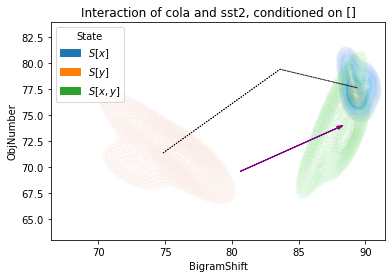

In [16]:
compute_interaction_effect("roberta", [], targetx="cola", targety="sst2", features=["BigramShift", "ObjNumber"], plot_fname="figures/cola_v_sst2_feat=BShift,ObjNumber_lm=roberta_nocondition.svg")

,feature,interaction_eff,p_value,significance
0,BigramShift,-10.20,0.000184,***
1,TopConstituents,2.16,0.009147,**


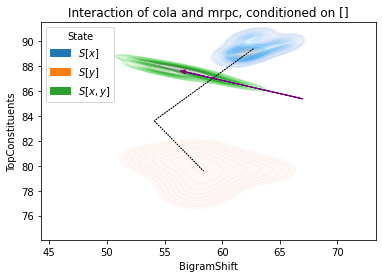

In [15]:
compute_interaction_effect("roberta", [], targetx="cola", targety="mrpc", features=["BigramShift", "TopConstituents"], plot_fname="figures/cola_v_sst2_feat=BShift,TopConstituents_lm=roberta_nocondition.svg")

,feature,interaction_eff,p_value,significance
0,Length,-6.02,0.001824,**
1,Tense,3.18,0.006261,**


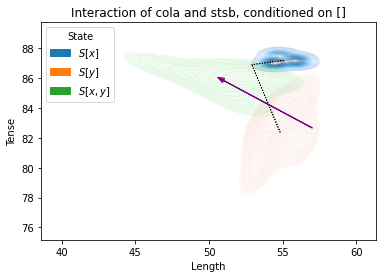

In [17]:
compute_interaction_effect("roberta", [], targetx="cola", targety="stsb", features=["Length", "Tense"], plot_fname="figures/cola_v_sst2_feat=Length,Tense_lm=roberta_nocondition.svg")

,feature,interaction_eff,p_value,significance
0,Length,-5.86,0.007858,**
1,Depth,-1.74,0.036966,*


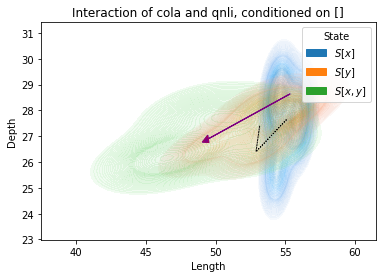

In [18]:
compute_interaction_effect("roberta", [], targetx="cola", targety="qnli", features=["Length", "Depth"], plot_fname="figures/cola_v_sst2_feat=Length,Depth_lm=roberta_nocondition.svg")

,feature,interaction_eff,p_value,significance
0,BigramShift,-4.0,0.017160,*
1,Length,2.0,0.002305,**


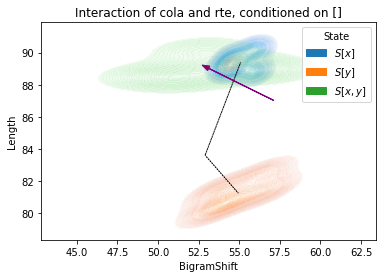

In [19]:
compute_interaction_effect("roberta", [], targetx="cola", targety="rte", features=["BigramShift", "Length"], plot_fname="figures/cola_v_rte_feat=BShift,Length_lm=roberta_nocondition.svg")

In [63]:
latex_df = {
    "targetx": [],
    "targety": [],
    "lm": [],
    "condition": []
}
for feat in probing_tasks:
    latex_df[feat] = []

for lm in ["roberta", "bert"]:
    for targetx in ["qnli"]:
        for targety in ft_tasks[ft_tasks.index(targetx):]:
            if targety == targetx:
                continue
            ret = compute_interaction_effect(lm, [], targetx, targety, probing_tasks, plot=False)
            latex_df["targetx"].append(targetx.upper())
            latex_df["targety"].append(targety.upper())
            latex_df["lm"].append(lm)
            latex_df["condition"].append([])
            for feat in probing_tasks:
                row = ret[ret.feature==feat]
                int_eff = row.interaction_eff.iloc[0]
                p_val = row.p_value.iloc[0]
                optional_hspace = ["", "\hspace{0.75em}"][int(int_eff>0)]
                latex_df[feat].append(
                    f"${optional_hspace}{int_eff:.2f}" + "^{" + p_to_stars(p_val) + "}$"
                )
print_df = pd.DataFrame(latex_df)
print(print_df.drop(columns=["condition"]).to_latex(escape=False, index=False))

\begin{tabular}{llllllllllll}
\toprule
targetx & targety &      lm &                   Length &      Depth & TopConstituents &              BigramShift &                    Tense & SubjNumber &                ObjNumber &                OddManOut &    CoordinationInversion \\
\midrule
   QNLI &     RTE & roberta &               $-0.10^{}$ & $-0.74^{}$ &      $-0.68^{}$ & $\hspace{0.75em}0.96^{}$ & $\hspace{0.75em}0.06^{}$ & $-0.76^{}$ & $\hspace{0.75em}1.30^{}$ & $\hspace{0.75em}0.40^{}$ & $\hspace{0.75em}1.86^{}$ \\
   QNLI &     RTE &    bert & $\hspace{0.75em}3.46^{}$ & $-1.32^{}$ &      $-2.12^{}$ & $\hspace{0.75em}0.12^{}$ & $\hspace{0.75em}0.36^{}$ & $-3.38^{}$ &             $-2.76^{**}$ & $\hspace{0.75em}0.70^{}$ &               $-1.20^{}$ \\
\bottomrule
\end{tabular}



/var/folders/5f/6nkzdmxs6hl7xl72dd7_m4cr0000gn/T/ipykernel_89391/3756245097.py:29: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(print_df.drop(columns=["condition"]).to_latex(escape=False, index=False))
